In [1]:
!pip install statsmodels
!pip install pmdarima

In [15]:
import some_fun

In [16]:
c = some_fun.sum_two(1,2)
c

3

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [3]:
from hdfs import InsecureClient
client = InsecureClient('http://datalake:50070')

client.status("/")
with client.read('/shared/havells_trail/raw/clean_forecast.csv', encoding = 'utf-8') as reader:
    data = pd.read_csv(reader, sep=",")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   material             480 non-null    object 
 1   calendar_year_month  480 non-null    int64  
 2   qty_final            480 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.4+ KB


In [5]:
data1 = data[data['material'] == 'a']
data1['calendar_year_month'] = pd.to_datetime(data1['calendar_year_month'], format='%Y%m', errors='coerce')
data1 = data1 [['calendar_year_month','qty_final']]
data1 = data1.set_index(['calendar_year_month'])
data1['istrain'] = np.where(data1.index < '2019-07-01',1,0)


In [6]:
train_df = data1[data1['istrain']==1]
test_df = data1[data1['istrain']==0]
Q1 = train_df['qty_final'].quantile(0.25)
Q3 = train_df['qty_final'].quantile(0.75)
IQR = Q3 - Q1
factor = 3
floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR

train_df = train_df[(train_df['qty_final'] >= floor) & (train_df['qty_final'] <= ceil)]


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=861.176, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=740.007, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=736.793, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=727.743, Time=0.30 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=729.674, Time=1.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=730.562, Time=2.80 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=715.059, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=715.943, Time=0.31 sec
 ARIMA(3,0

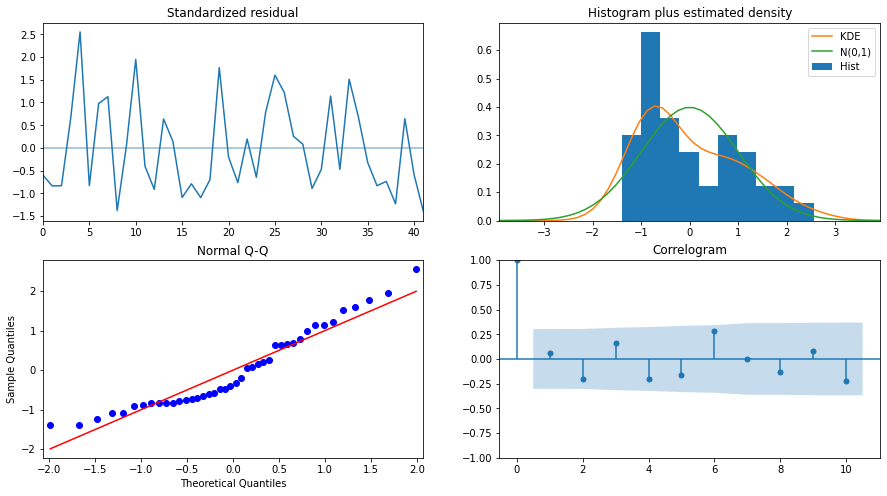

In [7]:
dep_var = 'qty_final'
model_autoARIMA = auto_arima(train_df[dep_var], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


In [8]:
fitted_values = model_autoARIMA.fit_predict(train_df[dep_var],n_periods=len(train_df))
forecast_values = model_autoARIMA.predict(n_periods=len(test_df))

In [9]:
forecast_values = pd.DataFrame(forecast_values)
forecast_values.index = test_df.index
forecast_values.columns = ["pred_aa_notran"]
    
fitted_values = pd.DataFrame(fitted_values)
fitted_values.index = train_df.index
fitted_values.columns = ["pred_aa_notran"]

In [10]:
output = pd.concat([fitted_values, forecast_values])
output

,pred_aa_notran
calendar_year_month,
2016-01-01,6605.166667
2016-02-01,6605.166667
2016-03-01,6605.166667
2016-04-01,6605.166667
2016-05-01,6605.166667
2016-06-01,6605.166667
2016-07-01,6605.166667
2016-08-01,6605.166667
2016-09-01,6605.166667


In [11]:
final_table = pd.concat([data1, output], axis =1)
final_table

,qty_final,istrain,pred_aa_notran
calendar_year_month,,,
2016-01-01,5945.0,1,6605.166667
2016-02-01,5685.0,1,6605.166667
2016-03-01,5690.0,1,6605.166667
2016-04-01,7344.0,1,6605.166667
2016-05-01,9419.0,1,6605.166667
2016-06-01,5692.0,1,6605.166667
2016-07-01,7683.0,1,6605.166667
2016-08-01,7848.0,1,6605.166667
2016-09-01,5087.0,1,6605.166667
